In [23]:
# google colab で実行する場合は以下のコメントアウトを外す
# ! wget https://indexes.nikkei.co.jp/nkave/historical/nikkei_stock_average_daily_jp.csv

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
from warnings import simplefilter
simplefilter("ignore", FutureWarning)  # FutureWarningを無視する
from statsmodels.tools.sm_exceptions import  ValueWarning, ConvergenceWarning
simplefilter("ignore", ValueWarning)  # ValueWarningを無視する
simplefilter("ignore", ConvergenceWarning)  # ConvergenceWarning

In [2]:
# 日経平均株価のデータフレームを作成
# (最後の行の利用方法の説明は、skipfooter=1 でデータフレームに取り込まない)
stock_df = pd.read_csv('nikkei_stock_average_daily_jp.csv', encoding='cp932', skipfooter=1, engine='python')['終値']
print('データ数', len(stock_df))
print('データフレームの末尾1行\n', stock_df.tail(1))

データ数 848
データフレームの末尾1行
 847    38403.23
Name: 終値, dtype: float64


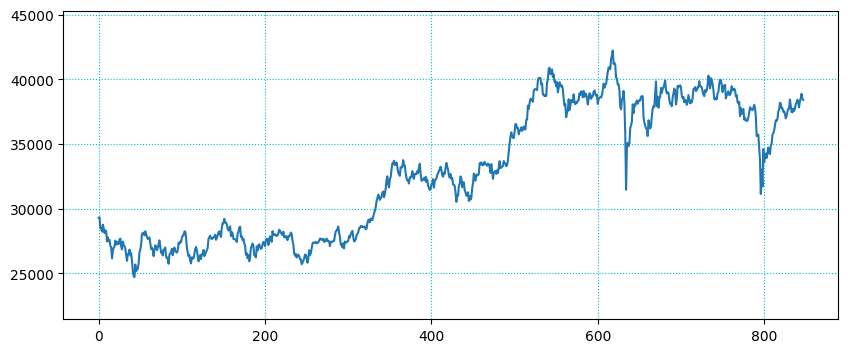

In [3]:
# 日経平均株価のグラフを表示
fig = plt.figure(figsize=(10,4))  
ax = fig.add_subplot(111)
ax.plot(stock_df)
y_min, y_max = ax.get_ylim()
ax.set_ylim(y_min * 0.9, y_max * 1.05)
ax.grid(axis='both',linestyle='dotted', color='c')

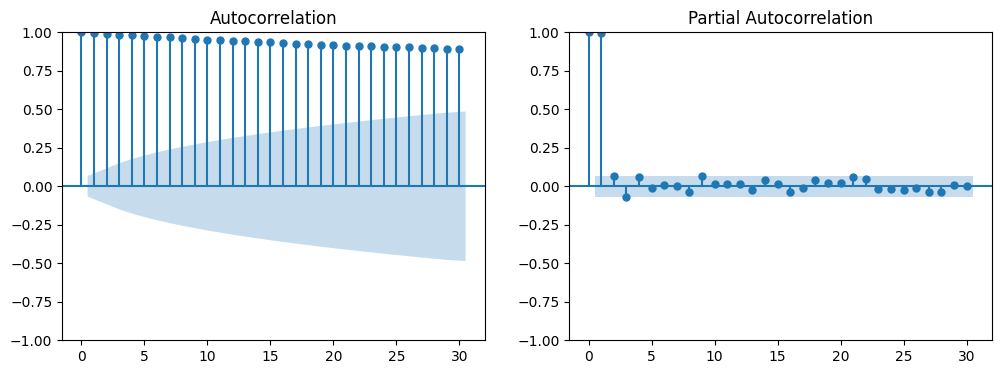

In [4]:
# 自己相関係数と偏自己相関係数のグラフを表示
fig = plt.figure(figsize=(12, 4))  
ax1 = fig.add_subplot(121)
fig = sm.graphics.tsa.plot_acf(stock_df, ax=ax1)
ax2 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_pacf(stock_df, ax=ax2, method='ywm')

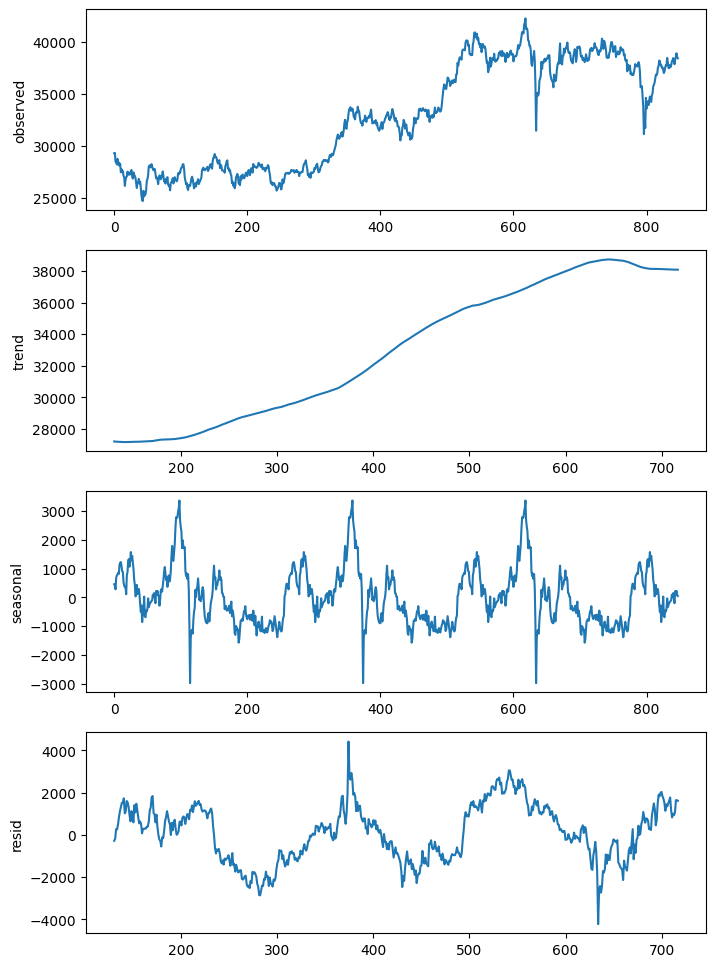

In [5]:
# 時系列データをトレンド、規則的変動成分、不規則変動成分に分解
# 260=5*52
res = sm.tsa.seasonal_decompose(stock_df, period=260) 
fig = plt.figure(figsize=(8, 12))
ax1 = fig.add_subplot(411)
ax1.set_ylabel('observed')
ax1.plot(res.observed)
ax2 = fig.add_subplot(412)
ax2.set_ylabel('trend')
ax2.plot(res.trend)
ax3 = fig.add_subplot(413)
ax3.set_ylabel('seasonal')
ax3.plot(res.seasonal)
ax4 = fig.add_subplot(414)
ax4.set_ylabel('resid')
ax4.plot(res.resid)


In [12]:
# モデル構築と検証のためのデータを準備
train_end = 820
train = stock_df[0:train_end]  # 学習用データ 
test = stock_df[train_end:]  # 検証用データ 

# グリッドサーチで最適なARIMAモデルを探索
p = d = q = range(0, 2) # パラメータ範囲の設定
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq] 

best_aic = np.inf # 最小AICを無限大で初期化
best_params = None # 最適なパラメータを格納する変数
# グリッドサーチを実行
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = sm.tsa.SARIMAX(train, order=param, seasonal_order=seasonal_param,
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
            results = model.fit(disp=False)
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
                print(f"New best AIC: {best_aic} with params {best_params}")
        except:
            continue

print(f"Best SARIMAX parameters: {best_params}")

New best AIC: 19370.925439975195 with params ((0, 0, 0), (0, 0, 0, 12))
New best AIC: 18528.940775507654 with params ((0, 0, 0), (0, 0, 1, 12))
New best AIC: 14042.526711004939 with params ((0, 0, 0), (0, 1, 0, 12))
New best AIC: 13788.419279662783 with params ((0, 0, 0), (0, 1, 1, 12))
New best AIC: 13785.617384207548 with params ((0, 0, 0), (1, 1, 1, 12))
New best AIC: 13431.011090682847 with params ((0, 0, 1), (0, 1, 0, 12))
New best AIC: 13134.196278956671 with params ((0, 0, 1), (0, 1, 1, 12))
New best AIC: 13128.519059946675 with params ((0, 0, 1), (1, 1, 1, 12))
New best AIC: 12387.37886800769 with params ((0, 1, 0), (0, 0, 0, 12))
New best AIC: 12210.015816547833 with params ((0, 1, 0), (0, 0, 1, 12))
New best AIC: 12069.969813060963 with params ((0, 1, 0), (0, 1, 1, 12))
New best AIC: 12049.206667341197 with params ((0, 1, 1), (0, 1, 1, 12))
Best SARIMAX parameters: ((0, 1, 1), (0, 1, 1, 12))


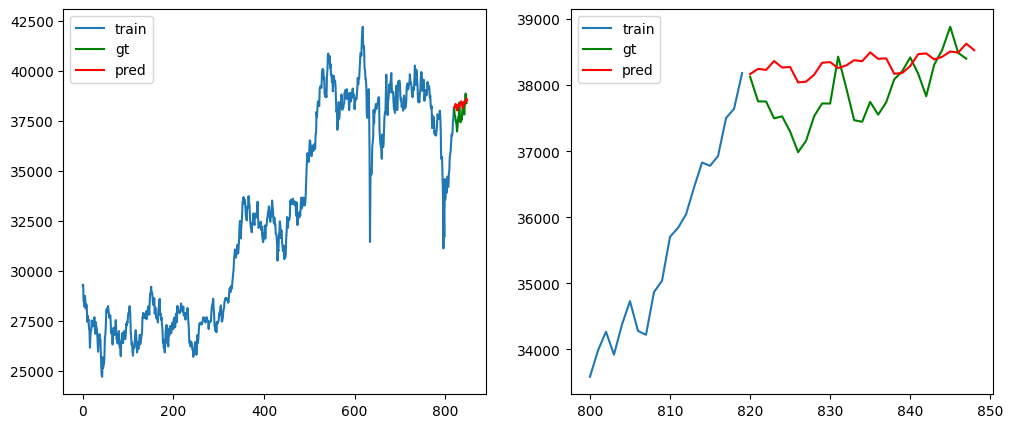

In [13]:
# pmdarima で探索した最適次数を利用してモデルを作成
train_end = 820
train = stock_df[0:train_end]  # 学習用データ 
test = stock_df[train_end:]  # 検証用データ 
SARIMA = sm.tsa.SARIMAX(train, order=best_params[0], seasonal_order=best_params[1],
                     enforce_stationarity=False, enforce_invertibility=False).fit()
pred = SARIMA.predict(820, len(stock_df))

# 実データと予測結果の図示
fig = plt.figure(figsize=(12, 5))  
ax1 = fig.add_subplot(121)
ax1.plot(train, label="train")
ax1.plot(test, "g", label="gt")
ax1.plot(pred, "r", label="pred")
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(stock_df[800:train_end], label="train")
ax2.plot(test, "g", label="gt")
ax2.plot(pred, "r", label="pred")
ax2.legend()

In [14]:
# モデル構築と検証のためのデータを準備
train_end = len(stock_df)
train = stock_df[0:train_end]  # 学習用データ 
test = stock_df[train_end:]  # 検証用データ 
train = stock_df  # 学習用データ 
# pmdarima で探索した最適次数を利用してモデルを作成
SARIMA = sm.tsa.SARIMAX(train, order=best_params[0], seasonal_order=best_params[1],
                     enforce_stationarity=False, enforce_invertibility=False).fit()
# 学習データの範囲の次の日の終値を予測して表示
pred = SARIMA.predict(len(stock_df)+1)
print('予測値', pred)

予測値 849    38340.397815
dtype: float64
